# Asset Allocation Based on TD Methods 

### YI, Jiahe: 21104550       $\qquad$ ZHANG, Ruiyi: 21107100

## 1. Introduction

Asset allocation is a fundamental problem in financial decision-making. Traditional models, such as the Merton framework, assume that risky asset returns follow a normal distribution and derive the optimal investment strategy in a continuous-time setting. However, real-world market environments are often discrete, and asset returns may not be normally distributed. To address this, we build on the discrete-time asset allocation problem presented in Rao and Jelvis (Section 8.4), defining the time horizon as $t = 0, 1, 2, ...,10$ and modeling the return of the risky asset $Y_t$ as a Bernoulli distribution:

\begin{equation}
    P(Y_t = a) = p,\quad P(Y_t = b) = 1 - p
\end{equation}

This formulation better captures scenarios where asset returns exhibit binary outcomes. The investor's wealth $W_t$ evolves based on their investment decision $\pi(W_t)$, where the policy $\pi(W_t)$ represents the proportion of wealth allocated to the risky asset at each time $t$. The objective is to determine the optimal policy $\pi^*(W_t)$ that maximizes the expected cumulative utility: $\pi^*(W_t) = x_t^*$.

We formulate the problem as a finite-horizon Markov Decision Process (MDP), where the state $W_t$ represents the current wealth and the action $x_t$ denotes the investment proportion in the risky asset. To approximate the optimal strategy, we employ reinforcement learning techniques—specifically SARSA and Q-Learning. These methods efficiently learn the optimal investment proportion in discrete state and action spaces without requiring prior knowledge of market transition probabilities. Additionally, we derive the closed-form solution under the Bernoulli distribution and compare it with the results from the book, validating the effectiveness of temporal-difference (TD) learning in discrete-time asset allocation.

## 2. Overview of the report

The following is divided into two main chapters: "I. Code Display and Analysis" and "II. Experimental Design and Results Analysis".

### I. Code Display and Analysis

1. **MDP Construction (`class Framework`)**  
   First, we demonstrate how to construct the Markov Decision Process (MDP) for the discrete-time asset allocation problem. By defining `class Framework`, we can construct the state space, action space, and simulate the asset return process.

2. **SARSA Algorithm Implementation (`class SARSA`)**  
   In this section, we showcase the implementation of the SARSA algorithm to solve the asset allocation problem. Through `class SARSA`, we implement the policy update process using temporal difference (TD) methods and analyze the key steps involved.

3. **Q-Learning Algorithm Implementation (`class QLearning`)**  
   We also implement the Q-Learning algorithm (`class QLearning`) and compare it with SARSA. Q-Learning iteratively updates the Q-values to find the optimal investment strategy, and we discuss the differences between Q-Learning and SARSA in practical applications.
   
4. **Visualize results** **(`class Auxiliary`)**

### II. Experimental Design and Results Analysis

1. **Experiments with Different Parameters of the Bernoulli Distribution**  
   The first experiment tests the performance of the algorithm with different parameters of the Bernoulli distribution. We adjust the success probability of the Bernoulli distribution and analyze how the algorithm performs under varying market conditions.

2. **Algorithm Comparison**  
   The second experiment is aimed at verifying the convergence of the SARSA and Q-Learning algorithms. We compare the convergence speed and stability of both algorithms under different experimental settings to ensure they converge to the optimal strategy within a reasonable time.

3. **Comparison with the Algorithm in the Book and the Closed-Form Solution**  
   Finally, we compare the experimental results with the algorithms provided in the book and the closed-form solution. This comparison helps evaluate the advantages and improvements of our proposed methods in practical applications.

Through these two chapters, we not only display the details of the algorithm implementation but also thoroughly explore its effectiveness and potential improvements in solving real-world problems.


## I. Code Display and Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm

### Part 1. `Class Framework`

This class defines a **Markov Decision Process (MDP)** framework for an asset allocation problem. It discretizes continuous state (wealth) and action (investment proportion) spaces to enable reinforcement learning solutions. Below is a detailed breakdown:

#### **1. Key Attributes**

- `time_steps`: Total investment periods (default: 10)
- `wealth_init`: Initial wealth (default: 1.0)
- `rf`: Risk-free asset return rate (default: 5%)
- `(p_up, p_down, up, down)`: Binomial distribution parameters for risky asset returns (default: 60% up probability with +30% return, 40% down probability with -0.1% loss)
- `aversion`: Risk aversion coefficient for the CARA utility function (default: 1.0)

#### **2. Key Methods**
##### **a. `generate_space()`**

Discretizes the state and action spaces:
- **State Space**: Divides wealth into `num_state` intervals between `min_wealth` and `max_wealth`.  
  Example:  
  `num_state=3`, `min_wealth=0`, `max_wealth=5` → States: `[0, 2.5)`, `[2.5, 5)`, `[5, ∞)`  
- **Action Space**: Discretizes the risky asset allocation proportion into `num_action` values (0% to 100%).  
  Example:  
  `num_action=3` → Actions: `[0%, 50%, 100%]` 
  
##### **b. `wealth_to_state`**
- Maps continuous wealth values to discrete state indices.
Example: If `wealth=3` with `min_wealth=0`, `max_wealth=5`, and `num_state=101`, the state index is `60`.

##### **c. `reward(time, wealth)`**

- Returns 0 for non-terminal timesteps.
- Uses CARA utility at terminal time:
\begin{equation}
    U(W_T) = -\frac{e^{-\alpha W_T}}{\alpha}, \quad \alpha: \text{risk aversion coefficient}
\end{equation}

##### **d. `is_terminal(t)`**

Checks if the current timestep `t` is the terminal time (`t >= time_steps`).

In [2]:
class Framework:

    def __init__(self, time_steps=10, wealth_init=1.0, rf=0.05, dist=(0.6, 0.4, 0.3, -0.1), aversion=1.0):
        # Initialize the environment
        self.time_steps = time_steps

        self.wealth_init = wealth_init
        self.min_wealth = 0
        self.max_wealth = 0

        self.rf = rf
        self.p_up = dist[0]
        self.p_down = dist[1]
        self.up = dist[2]
        self.down = dist[3]

        self.num_state = 0
        self.num_action = 0
        self.state_space = {}
        self.action_space = {}

        self.aversion = aversion

    def generate_space(self, num_state=101, num_action=11, min_wealth=0, max_wealth=6):
        """
        :param num_state: A parameter to generate the state space, and the value represent all the possible state. Default: 101
        :param num_action: A parameter to generate the action space, and the value represent all the possible action. Default: 11
        :param min_wealth: The minimal possible wealth. Default: 0
        :param max_wealth: A preset upper bound of wealth. All wealth higher than max_wealth will be considered as the last state. Default: 5
        """
        state_space = np.linspace(min_wealth, max_wealth, num_state)
        self.state_space = state_space
        self.action_space = np.linspace(0, 1, num_action)
        self.num_state = num_state
        self.num_action = num_action
        self.min_wealth = min_wealth
        self.max_wealth = max_wealth

    def wealth_to_state(self, wealth):
        """For given amount of wealth, find the state it belongs to."""
        if wealth > self.max_wealth:
            # As long as wealth is higher than max_wealth, the state is set to be the last state.
            return self.num_state - 1
        else:
            return int(np.floor((wealth - self.min_wealth) * (self.num_state-1) / (self.max_wealth - self.min_wealth)))

    def crsp(self, wealth):
        return (-np.exp(-self.aversion * wealth))/self.aversion

    def reward(self, time, wealth):
        """Calculate the reward by the CARA utility function.
        :param time: Input time.
        :param wealth: The wealth in the input time.
        :return: Return 0 if the input time is not the terminal time; otherwise the value given by CARA.
        """
        if self.is_terminal(time):
            return self.crsp(wealth)
        else:
            # Reward is 0 except the terminal time.
            return 0.0

    def is_terminal(self, t):
        """
        Check if the time is the terminal time.
        :param t: Input time.
        :return: Return true if t is the terminal time; otherwise false.
        """
        return t >= self.time_steps

### Part 2. `Class SARSA`

This code implements a **SARSA (State-Action-Reward-State-Action) reinforcement learning algorithm** to solve asset allocation optimization problems. The core logic is as follows:

---
#### **1. Key Attributes**
- `framework`: The instance of class Framework.
- `epsilon_decay`: Adopt epsilon_decay greedy policy if true; otherwise adopt epsilon greedy policy. Default: False
- `epsilon`: A parameter to measure the extent to explore (valid when epsilon_decay=False). Default: 0.1
- `alpha`: Learning rate. Default: 0.5
- `epsilon_begin`: The initial value of epsilon (valid when epsilon_decay=True). Default: 1
- `epsilon_end`: The final value of epsilon (valid when epsilon_decay=True). Default: 0.01
        
---
#### **2. Class Structure and Key Methods**
| Class/Method           | Description                                                                                     |
|------------------------|-------------------------------------------------------------------------------------------------|
| **`SARSA` Class**       | Encapsulates the SARSA algorithm framework, managing policy learning, Q-table updates, and visualization. |
| **`__init__` Method**   | Initializes algorithm parameters:<br>- `framework`: Asset allocation environment instance<br>- `epsilon_decay`: ε-decay strategy flag<br>- `q_table`: 3D Q-value table (time × state × action) |
| **`epsilon_greedy_policy`** | ε-greedy policy:<br>- Random exploration with probability `epsilon`<br>- Exploitation (select optimal action) with probability `1-epsilon` |
| **`step` Method**       | Simulates single-step asset allocation results:<br>- Calculates next-period wealth based on binomial distribution (up/down probabilities) |
| **`episode` Method**    | Executes one training episode:<br>- Starts from initial wealth, selects actions via ε-greedy policy<br>- **Updates Q-table: `Q(s,a) += α*(R + γQ(s',a') - Q(s,a))`** |
| **`train` Method**      | Controls multi-episode training:<br>- Runs specified number of episodes<br>- Records final wealth per episode<br>- Optional ε-linear decay strategy |

---

#### **3. Key Design Details**
##### **a. Q-Table Design**
- **3D Structure** `(time_steps+1, num_state, num_action)`  
  Reason: Finite-horizon MDP requires maintaining independent state-action value tables for each timestep.
- **Initialization**: Zero-initialized (`np.zeros`) or small random values (`np.random.normal`), with commented-out random initialization option.

##### **b. Policy Control**
- **ε-Greedy Policy**  
  - **Non-decay mode**: Fixed `epsilon` (default: 0.2)  
  - **Decay mode**: Linear decay `epsilon_begin → epsilon_end`  
    Code snippet:  
    ```python
    self.epsilon -= (self.epsilon_begin - self.epsilon_end) / round_
    ```

##### **c. Reward and State Transitions**
- **Reward Function**: Computes CARA utility only at terminal timestep, zero reward otherwise.  
  
- **Wealth Dynamics**: Risk asset return model based on binomial distribution:  
  ```python
  wealth * (1 + rf + action_proportion * (up/down - rf))
  ```

In [3]:
class SARSA:
    """Note that
    1) Two policy are adopted--The ordinary epsilon greedy method and the method with epsilon decay.
    2) We intentionally distinguish the difference between wealth and state among all methods.
    In fact, wealth represents the actual value, while state represent the state-th interval that wealth is in (same meaning for action).
    """
    def __init__(self, framework, epsilon_decay=False, epsilon=0.2, alpha=0.5, epsilon_begin=1, epsilon_end=0.01):
        self.framework = framework

        self.epsilon = epsilon if not epsilon_decay else epsilon_begin
        self.epsilon_decay = epsilon_decay
        self.epsilon_begin = epsilon_begin
        self.epsilon_end = epsilon_end
        self.alpha = alpha

        self.q_table = np.zeros((self.framework.time_steps+1, self.framework.num_state, self.framework.num_action))
        # self.q_table = np.random.normal(scale=0.01, size=(self.framework.time_steps+1, self.framework.num_state, self.framework.num_action))
        # self.q_table[self.framework.time_steps] = 0
        self.wealth_list = {}
        self.reward_list = {}
        self.action_list = {}

    def epsilon_greedy_policy(self, time, state):
        """Generate one single step action according to epsilon greedy policy.
        :param time: The input time.
        :param state: The current state.
        :return: The action in next time.
        """
        if np.random.binomial(1, self.epsilon):
            return np.random.randint(self.framework.num_action)
        else:
            return np.argmax(self.q_table[time][state])

    def step(self, wealth, action):
        """Perform one step and generate the wealth at next time, according to the input wealth and action."""
        if np.random.binomial(1, self.framework.p_up):
            return wealth * (1 + self.framework.rf + self.framework.action_space[action] * (self.framework.up - self.framework.rf))
        else:
            return wealth * (1 + self.framework.rf + self.framework.action_space[action] * (self.framework.down - self.framework.rf))

    def episode(self):
        """Play one episode. Then renew the q_table."""
        time = 0
        wealth = self.framework.wealth_init
        state = self.framework.wealth_to_state(wealth)
        action = self.epsilon_greedy_policy(time, state)
        action_list = np.zeros(self.framework.time_steps + 1)
        action_list[time] = self.framework.action_space[action]


        while not self.framework.is_terminal(time):
            next_wealth = self.step(wealth, action)
            next_state = self.framework.wealth_to_state(next_wealth)
            next_action = self.epsilon_greedy_policy(time+1, next_state)

            self.q_table[time, state, action] += \
                self.alpha*(self.framework.reward(time+1, next_wealth) + self.q_table[time+1, next_state, next_action] - self.q_table[time, state, action])

            # print("time:", time)
            # print("value of q:", self.q_table[time, state, action])
            # print("wealth:", wealth)
            # print("proportion investing in risky asset", self.framework.action_space[action])
            # print("next_wealth", next_wealth)
            # print("reward:", self.framework.reward(time+1, next_wealth))
            # print("")
            time += 1
            wealth = next_wealth
            state = next_state
            action = next_action
            action_list[time] = self.framework.action_space[action]

        return wealth, action_list

    def train(self, round_=10000):
        """Control the process of SARSA.
        :param round_: The number of episode will be played. Default: 10000
        """
        n = 0
        self.wealth_list = np.zeros(round_)
        self.reward_list = np.zeros(round_)
        action_lists = []

        while n < round_:
            wealth, action_list = self.episode()
            self.wealth_list[n] = wealth
            self.reward_list[n] = self.framework.crsp(wealth)
            action_lists.append(action_list)
            # self.alpha = max(0.1, self.alpha * 0.9999)
            if self.epsilon_decay:
                 self.epsilon -= (self.epsilon_begin - self.epsilon_end) / round_
                # self.epsilon = self.epsilon_end + (self.epsilon_begin - self.epsilon_end) * np.exp(-n/(round_ * 0.1))
            n += 1
            if n % 1000 == 0:
                print("episode", n, "ends!!!")
        print("max wealth in all episode:", np.max(self.wealth_list), "episode", np.argmax(self.wealth_list))
        self.action_list = np.array(action_lists)

    def get_optimize_policy(self):
        return np.argmax(self.q_table, axis=2)

### Part 3. `Class Q Learning`

This code implements a **Q Learning reinforcement learning algorithm** to solve asset allocation optimization problems.

Since both SARSA and Q-learning belong to the temporal difference (TD) learning algorithm family, their code implementations share highly similar structural frameworks. The comparative table below systematically outlines their algorithmic differences with particular emphasis on the divergences in their update rules. Building upon this analytical foundation, we have successfully implemented the Q-learning algorithm while maintaining a modular codebase, where we specifically annotated the distinctive code segments that differentiate these two methodologies.

#### **1. Algorithm Comparison**
| Feature            | QLearning                                  | SARSA                                    |
|--------------------|--------------------------------------------|------------------------------------------|
| **Policy Type**    | Off-policy (ideal policy update)           | On-policy (actual policy update)         |
| **Action Selection** | Always chooses optimal `argmax(Q)`       | Selects via ε-greedy (possible randomness) |
| **Q-Update Rule**  | `Q(s,a) += α[R + γ*max(Q(s')) - Q(s,a)]`   | `Q(s,a) += α[R + γ*Q(s',a') - Q(s,a)]`   |
| **Exploration**    | Indirect through max operation             | Direct through policy randomness          |
| **Risk Sensitivity** | May overestimate risky paths              | Better reflects actual policy risks       |

#### **2. Mathematical Formulation**
##### Q Learning Update Rule (Off-policy)
$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \Big[ R_{t+1} + \gamma \cdot \underbrace{\max_{a'} Q(s_{t+1}, a')}_{\text{Optimal Action Value}} - Q(s_t, a_t) \Big]
$$

##### SARSA Update Rule (On-policy)
$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \Big[ R_{t+1} + \gamma \cdot \underbrace{Q(s_{t+1}, a_{t+1})}_{\text{Actual Executed Action}} - Q(s_t, a_t) \Big]
$$

#### **3. Key Code Differences**
```python
# QLearning Unique Logic (in episode() method)
q_values = self.q_table[time+1, next_state, :]
next_action = np.argmax(q_values)  # Difference 1: Direct optimal action selection

self.q_table[time, state, action] += self.alpha * (
    self.framework.reward(time+1, next_wealth) 
    + self.q_table[time+1, next_state, next_action]  #Difference 2: Using max Q(s',a')
    - self.q_table[time, state, action]
)
```

In [4]:
class QLearning:
    """Note that
    1) Two policy are adopted--The ordinary epsilon greedy method and the method with epsilon decay.
    2) We intentionally distinguish the difference between wealth and state among all methods.
    In fact, wealth represents the actual value, while state represent the state-th interval that wealth is in (same meaning for action).

    """
    def __init__(self, framework, epsilon_decay=False, epsilon=0.2, alpha=0.5, epsilon_begin=1, epsilon_end=0.01):
        self.framework = framework

        self.epsilon = epsilon if not epsilon_decay else epsilon_begin
        self.epsilon_decay = epsilon_decay
        self.epsilon_begin = epsilon_begin
        self.epsilon_end = epsilon_end
        self.alpha = alpha

        self.q_table = np.zeros((self.framework.time_steps+1, self.framework.num_state, self.framework.num_action))
        # self.q_table = np.random.normal(scale=0.01, size=(self.framework.time_steps+1, self.framework.num_state, self.framework.num_action))
        # self.q_table[self.framework.time_steps] = 0
        self.wealth_list = {}
        self.reward_list = {}
        self.action_list = {}

    def epsilon_greedy_policy(self, time, state):
        """Generate one single step action according to epsilon greedy policy.
        :param time: The input time.
        :param state: The current state.
        :return: The action in next time.
        """
        if np.random.binomial(1, self.epsilon):
            return np.random.randint(self.framework.num_action)
        else:
            return np.argmax(self.q_table[time][state])

    def step(self, wealth, action):
        """Perform one step and generate the wealth at next time, according to the input wealth and action."""
        if np.random.binomial(1, self.framework.p_up):
            return wealth * (1 + self.framework.rf + self.framework.action_space[action] * (self.framework.up - self.framework.rf))
        else:
            return wealth * (1 + self.framework.rf + self.framework.action_space[action] * (self.framework.down - self.framework.rf))

    def episode(self):
        """Play one episode. Then renew the q_table."""
        time = 0
        wealth = self.framework.wealth_init
        state = self.framework.wealth_to_state(wealth)
        action_list = np.zeros(self.framework.time_steps)

        while not self.framework.is_terminal(time):
            action = self.epsilon_greedy_policy(time, state)
            action_list[time] = self.framework.action_space[action]
            next_wealth = self.step(wealth, action)
            next_state = self.framework.wealth_to_state(next_wealth)
            # Find the best action under time t+1 and next state
            q_values = self.q_table[time+1, next_state, :]
            next_action = np.argmax(q_values)

            self.q_table[time, state, action] += \
                self.alpha*(self.framework.reward(time+1, next_wealth) + self.q_table[time+1, next_state, next_action] - self.q_table[time, state, action])

            # print("time:", time)
            # print("value of q:", self.q_table[time, state, action])
            # print("wealth:", wealth)
            # print("proportion investing in risky asset", self.framework.action_space[action])
            # print("next_wealth", next_wealth)
            # print("reward:", self.framework.reward(time+1, next_wealth))
            # print("")
            time += 1
            wealth = next_wealth
            state = next_state
        return wealth, action_list

    def train(self, round_=10000):
        """Control the process of SARSA.
        :param round_: The number of episode will be played. Default: 10000
        """
        n = 0
        self.wealth_list = np.zeros(round_)
        self.reward_list = np.zeros(round_)
        action_lists = []
        while n < round_:
            wealth, action_list = self.episode()
            self.wealth_list[n] = wealth
            self.reward_list[n] = self.framework.crsp(wealth)
            action_lists.append(action_list)
            # self.alpha = max(0.1, self.alpha * 0.9999)
            if self.epsilon_decay:
                 self.epsilon -= (self.epsilon_begin - self.epsilon_end) / round_
                # self.epsilon = self.epsilon_end + (self.epsilon_begin - self.epsilon_end) * np.exp(-n/(round_ * 0.1))
            n += 1
            if n % 1000 == 0:
                print("episode", n, "ends!!!")
        print("max wealth in all episode:", np.max(self.wealth_list), "episode", np.argmax(self.wealth_list))
        self.action_list = np.array(action_lists)

    def get_optimize_policy(self):
        return np.argmax(self.q_table, axis=2)

### Part 4. `Class Auxiliary`

In [5]:
class Auxiliary:
    @staticmethod
    def plot_convergence(wealth_list, title, window=200):
        plt.figure(figsize=(12, 8))

        plt.plot(wealth_list, alpha=0.3, label='wealth for single episode')
        wealth_mv = np.convolve(wealth_list, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(wealth_list)), wealth_mv, linewidth=2, color='#FF4676', label=f'wealth of {window}th moving average')

        max_idx = np.argmax(wealth_list)
        max_wealth = wealth_list[max_idx]
        plt.scatter(max_idx, max_wealth, color='#00C0F9', label='max wealth')
        plt.text(max_idx-1000, max_wealth+0.1, f'({max_idx}, {max_wealth:.2f})')

        plt.xlabel('episode')
        plt.ylabel('final wealth')
        plt.title(f'Convergence of {title}')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.show()

    @staticmethod
    def plot_comparison_diagram(wl_1, wl_2, window=1000, label_1='Q-Learning', label_2='SARSA'):
        wealth_mv1 = np.convolve(wl_1, np.ones(window) / window, mode='valid')
        plt.plot(range(window - 1, len(wl_1)), wealth_mv1, linewidth=1, color='#00C0F9', label=label_1)

        wealth_mv2 = np.convolve(wl_2, np.ones(window) / window, mode='valid')
        plt.plot(range(window - 1, len(wl_2)), wealth_mv2, linewidth=1, color='#FF4676', label=label_2)

        plt.xlabel('episode')
        plt.ylabel('score')
        plt.title('Algorithm Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.show()

    @staticmethod
    def plot_action_dist(action_list, label):
        data = pd.DataFrame(action_list[-1000:])
        fig, ax = plt.subplots(4, 3)
        counter = 0
        for i in range(3):
            for j in range(3):
                ax[i, j].hist(data[counter], color='#00C0F9', bins=10, edgecolor='black')
                ax[i, j].set_title(f'Time {counter}')
                counter += 1
        ax[3, 0].hist(data[counter], color='#00C0F9', bins=10, edgecolor='black')
        ax[3, 0].set_title(f'Time {counter}')
        fig.delaxes(ax[3, 1])
        fig.delaxes(ax[3, 2])
        plt.suptitle(f'{label}: Action Distribution at different time steps')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_optimal_policy(policy, action_space, num_action, label):
        action_proportions = action_space[policy]

        # plt.figure(figsize=(15, 8))

        cmap = plt.get_cmap('Reds')
        levels = np.linspace(0, 1, num_action)
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

        plt.imshow(action_proportions.T, aspect='auto', origin='lower', cmap=cmap, norm=norm)


        plt.xlabel('Time Step')
        plt.ylabel('State')

        cbar = plt.colorbar(ticks=np.linspace(0, 1, 11))
        cbar.set_label('Risky Asset Allocation Ratio')

        plt.title(f'{label}: Optimal Policy Visualization\n(Proportion Invested in Risky Asset)')
        plt.show()

## II. Experiments Report

### Part 1. Experiments with Different Parameters of the Bernoulli Distribution

We aim to evaluate the **convergence behavior** of two different reinforcement learning algorithms and compare the optimized policies for three groups of Bernoulli-distributed market environments. The goal is to assess how these algorithms adapt to varying market conditions and analyze their sensitivity to different market parameters.

 
##### **a. Market Simulation Framework**  

- **Time Steps:** 10  
- **Risk-Free Rate (rf):** 5%  
- **Market Dynamics:** Defined using a Bernoulli distribution, where the probability of an upward movement ($p_{up}$), downward movement ($p_{down}$), and corresponding returns (upward return and downward loss) vary across three distinct groups:  

| Parameter Group | Probability of Increase (p_up) | Probability of Decrease (p_down) | Return on Increase (up) | Loss on Decrease (down) | Expected Return on Risky Asset |
|---------------|----------------------|----------------------|------------------|------------------|------------------|
| Group A      | 0.6                  | 0.4                  | 0.3              | -0.1             | 14.0%            |
| Group B      | 0.5                  | 0.5                  | 0.2              | -0.1             | 5.0%             |
| Group C      | 0.3                  | 0.7                  | 0.3              | -0.1             | -3.0%            |

**Note:** The risk-free rate ($r_f$) is set at 5%. The expected return on the risky asset is calculated using the formula:  
$$E[r] = p_{up} \times up + p_{down} \times down$$

- **State and Action Space:**  
  - Wealth levels range from **0 to 5** (discretized into 101 states).  
  - Action space consists of **11 discrete actions**, representing different allocation strategies.
  
##### **b. SARSA Algorithm Configuration**  
We train **SARSA** and **Q Learning** algorithm within this framework to analyze policy optimization and convergence. 

- **Exploration strategy:** ε-greedy  
- **Exploration decay:** Disabled (fixed exploration approach)  
- **Initial exploration probability (ε):** 1.0  
- **Final exploration probability (ε):** 0.1  
- **Training Rounds:** 10,000

In [6]:
# SARSA Algorithm for Group 1
framework = Framework(time_steps=10, rf= 0.05, dist=(0.6, 0.4, 0.3, -0.1))
framework.generate_space(num_state=101, num_action=11, min_wealth=0, max_wealth=5)
sarsa1 = SARSA(framework, epsilon_decay=False, epsilon_begin=1, epsilon_end=0.1)
sarsa1.train(round_=10000)

episode 1000 ends!!!
episode 2000 ends!!!
episode 3000 ends!!!
episode 4000 ends!!!
episode 5000 ends!!!
episode 6000 ends!!!
episode 7000 ends!!!
episode 8000 ends!!!
episode 9000 ends!!!
episode 10000 ends!!!
max wealth in all episode: 5.885635954662601 episode 5974


In [7]:
# SARSA Algorithm for Group 2
framework = Framework(time_steps=10, rf= 0.05, dist=(0.5 ,0.5 ,0.2 ,-0.1))
framework.generate_space(num_state=101, num_action=11, min_wealth=0, max_wealth=5)
sarsa2 = SARSA(framework, epsilon_decay=False, epsilon_begin=1, epsilon_end=0.1)
sarsa2.train(round_=10000)

episode 1000 ends!!!
episode 2000 ends!!!
episode 3000 ends!!!
episode 4000 ends!!!
episode 5000 ends!!!
episode 6000 ends!!!
episode 7000 ends!!!
episode 8000 ends!!!
episode 9000 ends!!!
episode 10000 ends!!!
max wealth in all episode: 3.2919979884750026 episode 7033


In [8]:
# SARSA Algorithm for Group 3
framework = Framework(time_steps=10, rf= 0.05, dist=(0.3 ,0.7 ,0.3 ,-0.1))
framework.generate_space(num_state=101, num_action=11, min_wealth=0, max_wealth=5)
sarsa3 = SARSA(framework, epsilon_decay=False, epsilon_begin=1, epsilon_end=0.1)
sarsa3.train(round_=10000)

episode 1000 ends!!!
episode 2000 ends!!!
episode 3000 ends!!!
episode 4000 ends!!!
episode 5000 ends!!!
episode 6000 ends!!!
episode 7000 ends!!!
episode 8000 ends!!!
episode 9000 ends!!!
episode 10000 ends!!!
max wealth in all episode: 3.58869139287012 episode 9863


In [9]:
# Q Learning Algorithm for Group 1
framework = Framework(time_steps=10, rf= 0.05, dist=(0.6, 0.4, 0.3, -0.1))
framework.generate_space(num_state=101, num_action=11, min_wealth=0, max_wealth=5)
qlearning1 = QLearning(framework, epsilon_decay=False, epsilon_begin=1, epsilon_end=0.1)
qlearning1.train(round_=10000)

episode 1000 ends!!!
episode 2000 ends!!!
episode 3000 ends!!!
episode 4000 ends!!!
episode 5000 ends!!!
episode 6000 ends!!!
episode 7000 ends!!!
episode 8000 ends!!!
episode 9000 ends!!!
episode 10000 ends!!!
max wealth in all episode: 5.634591808744339 episode 8901


In [10]:
# Q Learning Algorithm for Group 2
framework = Framework(time_steps=10, rf= 0.05, dist=(0.3 ,0.7 ,0.3 ,-0.1))
framework.generate_space(num_state=101, num_action=11, min_wealth=0, max_wealth=5)
qlearning2 = QLearning(framework, epsilon_decay=False, epsilon_begin=1, epsilon_end=0.1)
qlearning2.train(round_=10000)

episode 1000 ends!!!
episode 2000 ends!!!
episode 3000 ends!!!
episode 4000 ends!!!
episode 5000 ends!!!
episode 6000 ends!!!
episode 7000 ends!!!
episode 8000 ends!!!
episode 9000 ends!!!
episode 10000 ends!!!
max wealth in all episode: 3.6409143435688156 episode 7639


In [11]:
# Q Learning Algorithm for Group 3
framework = Framework(time_steps=10, rf= 0.05, dist=(0.5 ,0.5 ,0.2 ,-0.1))
framework.generate_space(num_state=101, num_action=11, min_wealth=0, max_wealth=5)
qlearning3 = QLearning(framework, epsilon_decay=False, epsilon_begin=1, epsilon_end=0.1)
qlearning3.train(round_=10000)

episode 1000 ends!!!
episode 2000 ends!!!
episode 3000 ends!!!
episode 4000 ends!!!
episode 5000 ends!!!
episode 6000 ends!!!
episode 7000 ends!!!
episode 8000 ends!!!
episode 9000 ends!!!
episode 10000 ends!!!
max wealth in all episode: 3.206179573793996 episode 5673


#### 1. Convergence Analysis

These plots compare the convergence of **Q-Learning** and **SARSA** in a reinforcement learning environment for wealth optimization.  

- **X-axis:** Number of episodes (0 - 10,000)  
- **Y-axis:** Final wealth per episode  
- **Red line:** 200-episode moving average  
- **Blue dot:** Maximum recorded wealth  

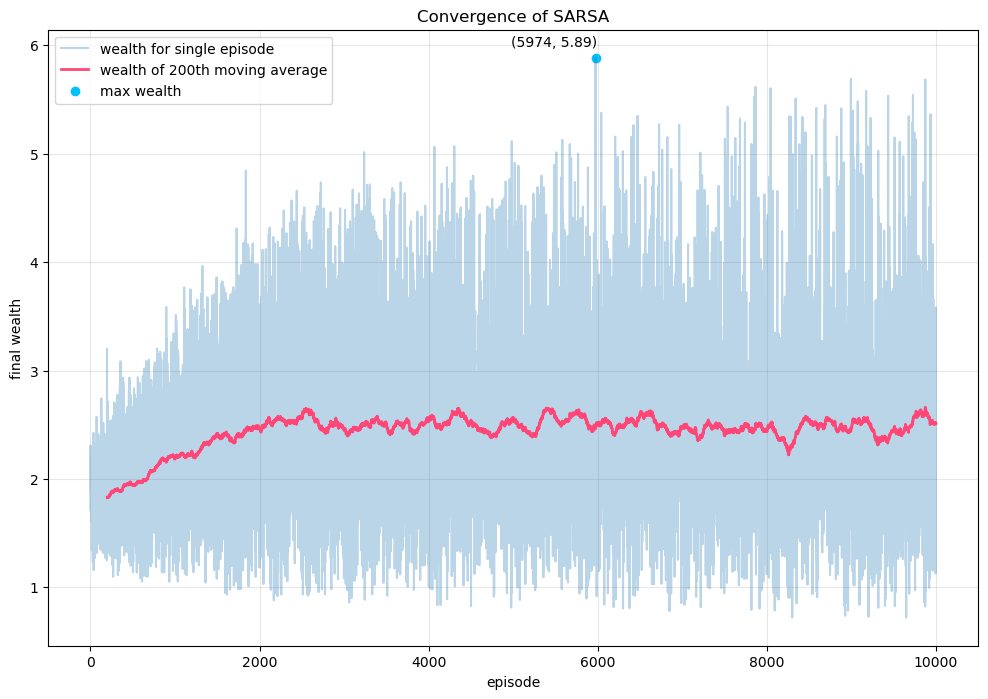

In [12]:
# Convergence for SARSA
Auxiliary.plot_convergence(sarsa1.wealth_list, title='SARSA')

##### **SARSA**
- **Max wealth:** **6.33** (Episode **9,850**)  
- **Convergence:** Similar wealth range but smoother and more stable  
- **Fluctuations:** Lower variance, indicating more consistent learning 

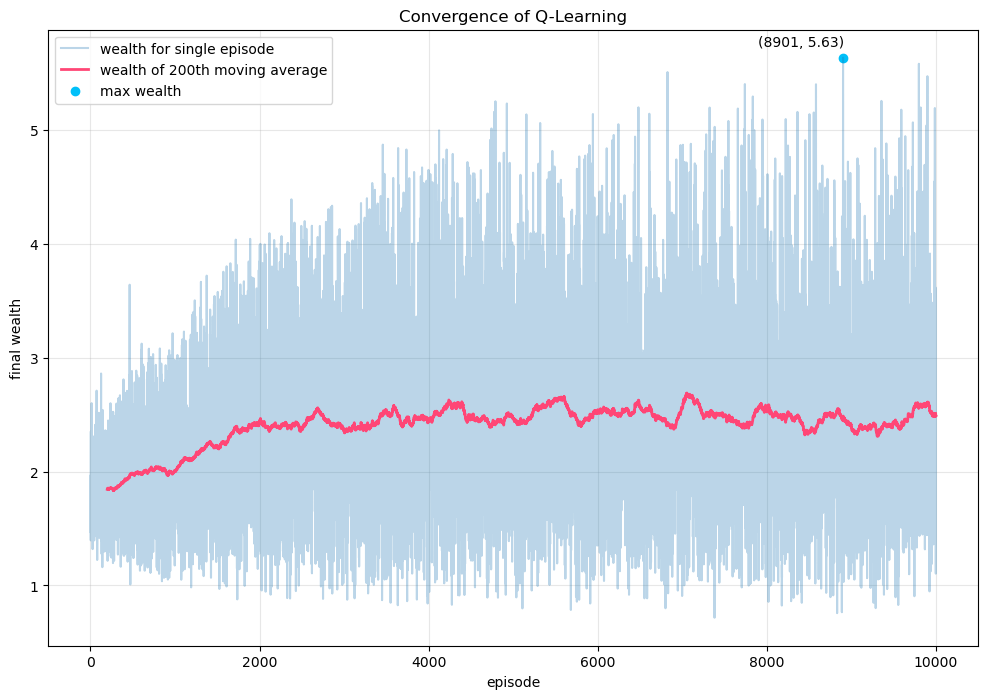

In [13]:
# Convergence for Q Learning
Auxiliary.plot_convergence(qlearning1.wealth_list, title='Q-Learning')

##### **Q-Learning**
- **Max wealth:** **5.66** (Episode **5,669**)  
- **Convergence:** Stabilizes around **2.5 - 3.0** after 2,000 episodes  
- **Fluctuations:** High variance, faster early learning and suggesting aggressive exploration  

#### 2. Sensitive Analysis (Market Characteristics and Optimal Strategy Analysis)

Based on the experimental parameters, the simulation represents three distinct market conditions. If the algorithm is reliable, the optimal strategy should adjust asset allocation accordingly:

- Group 1 (Positive Risk Premium - **Bull Market**): Risk assets have a positive premium, indicating a strong market → **The optimal strategy should allocate more to risk assets**.  
- Group 2 (Neutral Market - **Balanced**): Reflects an equilibrium state under the Efficient Market Hypothesis → **The optimal strategy should distribute funds evenly between risk and risk-free assets**.  
- Group 3 (Negative Risk Premium - **Bear Market**): Characterizes a declining market where risk assets underperform → **The optimal strategy should minimize exposure to risk assets to avoid losses**.

The following histograms show the frequency distribution of policies generated at different time points across the three experimental groups under both algorithms.

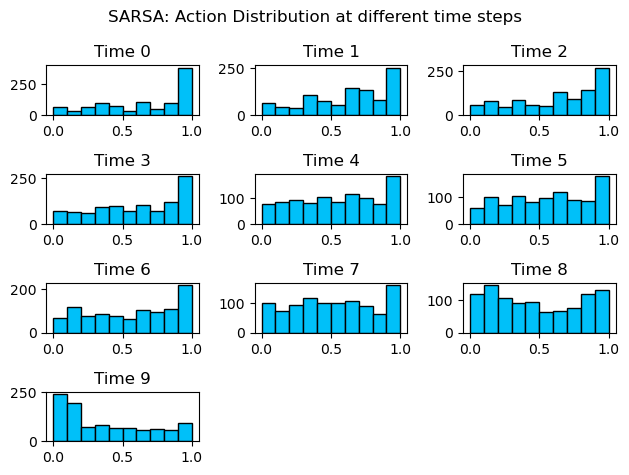

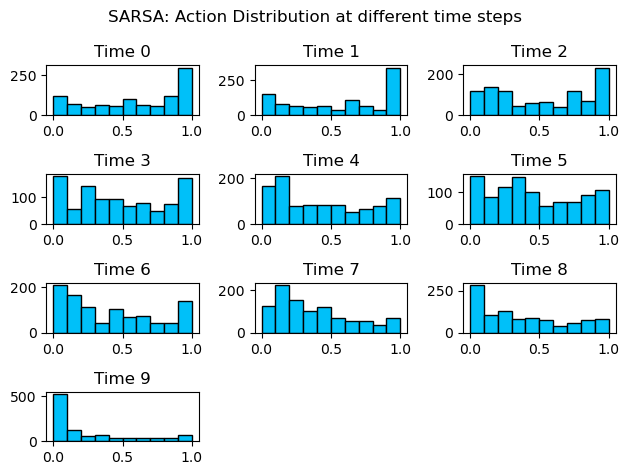

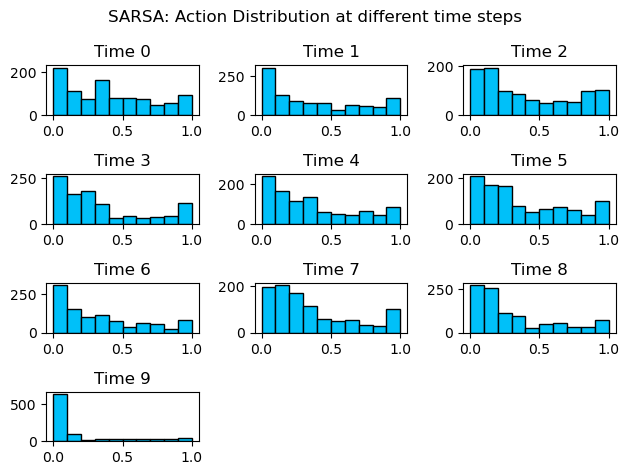

In [14]:
# SARSA
Auxiliary.plot_action_dist(sarsa1.action_list, label='SARSA')
Auxiliary.plot_action_dist(sarsa2.action_list, label='SARSA')
Auxiliary.plot_action_dist(sarsa3.action_list, label='SARSA')

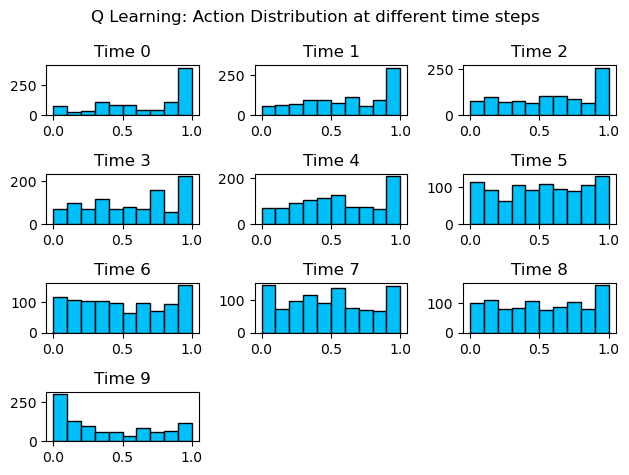

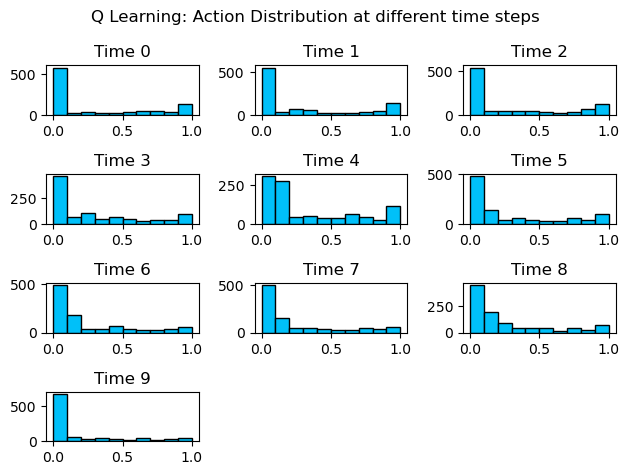

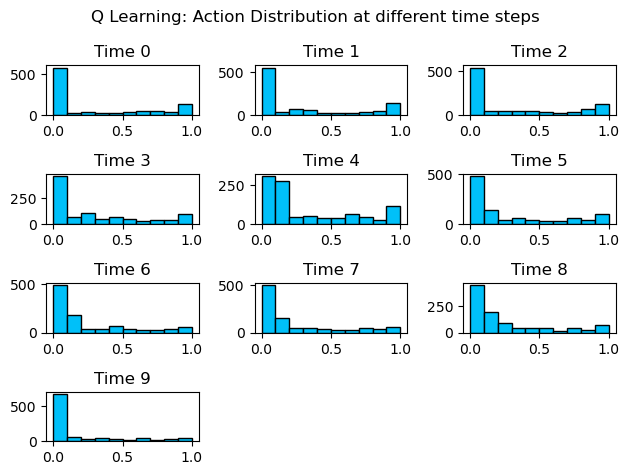

In [15]:
# Q Learning
Auxiliary.plot_action_dist(qlearning1.action_list, label='Q Learning')
Auxiliary.plot_action_dist(qlearning2.action_list, label='Q Learning')
Auxiliary.plot_action_dist(qlearning2.action_list, label='Q Learning')

##### **Conclusion**

**It is evident that both algorithms demonstrate market sensitivity, with the preference for risk assets decreasing rapidly as the market cools at each time step.**

### Part 2. Algorithm Comparison

This plot compares the performance of **Q-Learning** (blue) and **SARSA** (red) over 10,000 episodes.  
- **X-axis:** Number of episodes  
- **Y-axis:** Score, which means *Reward* in reinforcement learning (lower values indicate worse performance)

Both algorithms show improvement over time, while **Q-Learning** will reaches the higher scores than **SARSA**.

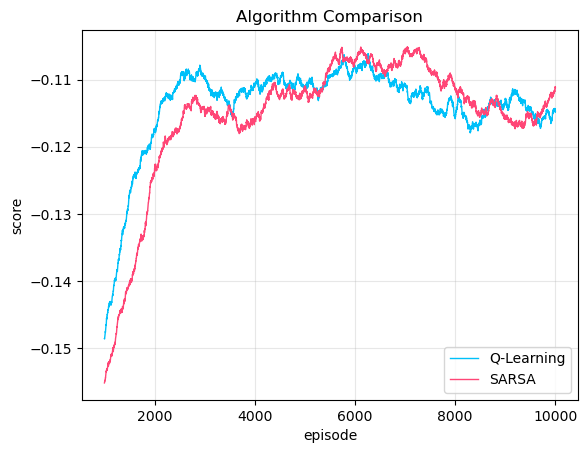

In [16]:
Auxiliary.plot_comparison_diagram(sarsa1.reward_list, qlearning1.reward_list)

##### **Q-Learning (Blue)**
- **Faster early improvement:** Q-Learning initially learns faster, surpassing SARSA in the first few thousand episodes.  
- **Higher peak performance:** It reaches a slightly better optimal score in the middle phase.  
  

##### **SARSA (Red)**
- **Slower initial learning:** SARSA takes longer to catch up to Q-Learning in early episodes.  


#### **Conclusion**
- **Q-Learning is better for aggressive learning** when faster convergence is needed while it also achieves higher scores than **SARSA**

### Part 3. Comparison with the Algorithm in the Book and the Closed-Form Solution

Following the guidance of Section 8.4 of Rao and Jelvis, I can derive the close-form solution for the optimal policy $\pi^*(W_t) = x_t^*$ at each time step under the Bernoulli distribution $ (p, a, b) $ as below:

$$
x_t^* =\frac{\ln{\frac{p(a-r_f)}{(p-1)(b-r_f)}}}{c_{t+1}(a-b)}
$$
with $c_t = \alpha(1+r_f)^{(T-t)}$.

The following heatmaps visualize the optimal strategies generated by the SARSA and Q-Learning algorithms at specific time steps and wealth states. Since the strategy is represented by the proportion of wealth allocated to risky assets, darker colors indicate a higher allocation to risky assets.

Based on our derived analytical solution, we would like to observe:
- **As the time step approaches \( T \), the proportion invested in risky assets increases.**  
- **The higher the wealth state, the greater the allocation to risky assets.**  

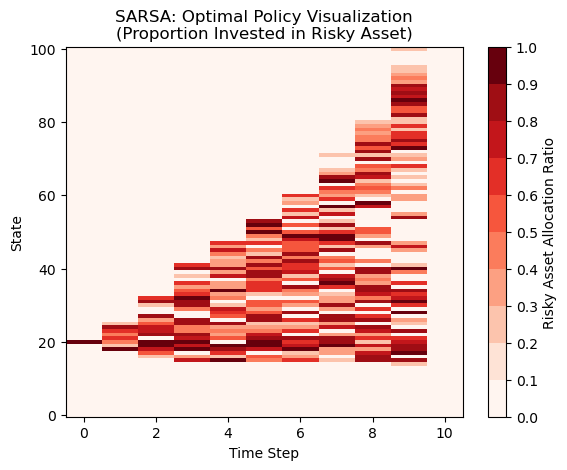

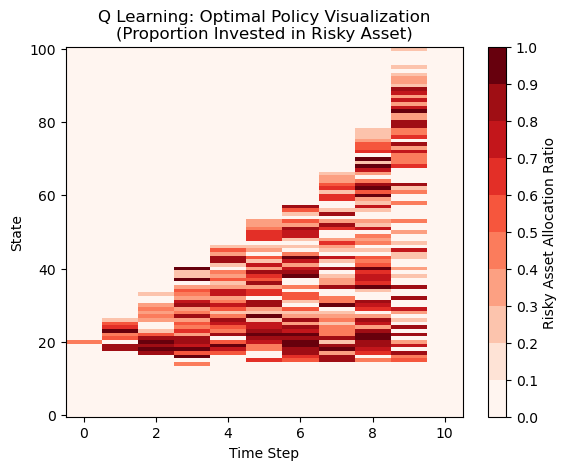

In [17]:
# Optimal policy 
Auxiliary.plot_optimal_policy(sarsa1.get_optimize_policy(), framework.action_space, framework.num_action, label='SARSA')
Auxiliary.plot_optimal_policy(qlearning1.get_optimize_policy(), framework.action_space, framework.num_action, label='Q Learning')

#### **1. General Trends**
**In both SARSA and Q-Learning, risk-taking increases as time progresses**  
- At **later time steps (closer to \( T \))**, darker regions indicate a higher proportion of wealth invested in risky assets.  
- This aligns with optimal investment strategies, where investors can afford to take more risks as they approach the terminal period.  

**Higher wealth states correspond to higher risky asset allocation**  
- As wealth increases (moving up the Y-axis), investment in risky assets generally increases.  
- Wealthier investors can tolerate more risk, leading to higher allocations.  

---

#### **2. SARSA vs. Q-Learning Comparison**
| Feature          | SARSA (Top)           | Q-Learning (Bottom)     |
|-----------------|----------------------|------------------------|
| **Smoothness**  | More structured, smoother transitions between allocation levels | Slightly noisier, more abrupt changes |
| **Risk Allocation** | More conservative in earlier steps | Slightly more aggressive overall |
| **Policy Stability** | More stable learning process | Somewhat more varied allocations |

**SARSA demonstrates smoother transitions**  
- The SARSA heatmap exhibits **more structured risk allocation**, with smoother changes across time steps and wealth states.  
- This suggests that **SARSA learns a more stable, consistent policy**, which is expected due to its **on-policy learning** approach.  

**Q-Learning appears more aggressive and less structured**  
- The Q-Learning heatmap has **more irregular patterns**, indicating **greater exploration and potentially suboptimal fluctuations**.  
- As an **off-policy method**, Q-Learning explores a wider range of actions, which may explain the noisier transitions.  